### Conjugate gradient method

#### Take-aways 

(Method and implementation)

- The algorithm of the conjugate gradient method for a system of linear equations.
- Summary about the conjugate gradient.
- Brief history.
- Computation 1: 3-by-3 example
- Computation 2: 1000-by-1000 example (Poisson problem)

**Problem of interest**

Given an $n$-by-$n$ symmetric positive definite (SPD) matrix $A$ and a $\mathbb{R}^n$-vector $b$, find $\mathbb{R}^n$-vector $x$ such that

$$ Ax = b. $$


#### Method: Conjugate gradient method

**Data**

- $x_0 \in \mathbb{R}^n$: initial guess

**Initialization**

- $d_0=r_0=b-Ax_0$

**Main computation**

- **for** k = 0, 1, 2, ..., $n$ - 1
    - **if** $r_k = 0$ **stop**, **end**
    - $\alpha_{k}=\frac{r_{k}^{T} r_{k}}{d_{k}^{T} A d_{k}}$ (compute $d_k$ component of error)
    - $x_{k+1}=x_{k}+\alpha_{k} d_{k}$ (subtract it out)
    - $r_{k+1}=r_{k}-\alpha_{k} A d_{k}$ (compute the new residual)
    - $\beta_{k}=\frac{r_{k+1}^{T} r_{k+1}}{r_{k}^{T} r_{k}}$ (compute $d_k$ component of the residual)
    - $d_{k+1}=r_{k+1}+\beta_{k} d_{k}$ (conduct Gram-Schmidt with respect to $A$-inner product)

    **end**

#### Summary

- The conjugate gradient (CG) method can solve $Ax=b$, where $A$ is symmetric positive definite.
- In theory, it finds the solution in at most $n$ steps, where $n$ is the dimension of the vectors $x$ and $b$. 
  - Hence, it can be seen as a direct method, i.e., yielding the true solution in finite number of steps. 
  - (Downside as a direct method) In terms of complexity, the CG requires about three times computations than Gaussian elimination as a direct method. ([^1] p. 131)
  - (Downside as direct method) It is known that if $A$ is ill-conditioned the round-off errors prevent it from giving the accurate solution. In fact, its performance is worse than Gaussian elimination. ([^1] p. 131)
- In practice, it can be better used as an iterative method.
  - If $A$ is sparse, the computational cost of the CG siginficantly drops since its main workhorse is matrix-vector multiplication ($Ad_k$ in the algorithm).
  - Introducing preconditioner enhance the performance of the CG for ill-conditioned matrices. 

[^1]: Sauer (2017) Numerical Analysis 

**History**

1. First proposed by Schmidt (1908) [^1] (*the* Schmidt in Gram-Schmidt)
1. Independently re-invented by Fox, Huskey, and Wilkinson (1948) [^2]
1. Hestenes and Stiefel (1952) made this idea explicit and practical. [^3]
1. It became popular only after Reid (1971) showed its value as an iterative method for large, sparse matrices. (CG is supposed to reach the solution in $n$ steps in theory, but it does not in practice due to round off errors. Reid founds its value in another way.)[^4] 

[^1]: Schmidt (1908) Uber die Auflosung linearer Gleichungen mit Unendlich vielen unbekannten (accent removed)

[^2]: Fox, Huskey, and Wilkinson (1948) Notes on the solution of algebraic linear simultaneous equations

[^3]: Hestenes and Stiefel (1952) Methods of conjugate gradients for solving linear systems 

[^4]: Reid (1971) On the method of conjugate gradients for the solution of large
	sparse systems of linear equations

In [1]:
import numpy as np

def CG(A, b, x0, tol=1e-9, max_iter=None):
    """
    Conjugate Gradient method for solving linear systems of equations.
    
    Parameters:
        A (ndarray): The coefficient matrix of the linear system.
        b (ndarray): The right-hand side vector of the linear system.
        x0 (ndarray): The initial guess for the solution.
        max_iter (int): The maximum number of iterations (default: 100).
        tol (float): The tolerance for convergence (default: 1e-9).
    
    Returns:
        x (ndarray): The approximate solution to the linear system.
        i (int): The number of iterations performed.
    """
    # default number of iterations is the dimension of the matrix
    if max_iter is None:
        n = A.shape[0]
        max_iter = n

    # initialize
    x = x0
    r = b - A @ x
    d = r

    r_nrm2 = np.dot(r, r)

    for i in range(1, max_iter + 1): 
        # intermediate computations part 1 
        Ad = A @ d

        # main conjugate gradient iteration part 1
        alpha = r_nrm2 / np.dot(d, Ad)
        x = x + alpha * d
        r_new = r - alpha * Ad
        
        # intermediate computations part 2
        r_new_nrm2 = np.dot(r_new, r_new)
        
        # stopping criterion
        if np.sqrt(r_new_nrm2) < tol:
            break

        # main conjugate gradient iteration part 2
        beta = r_new_nrm2 / r_nrm2
        d = r_new + beta * d
        
        # updata
        r = r_new
        r_nrm2 = r_new_nrm2
    
    return x, i


In [2]:
# A is of full rank
A = np.array([  [1, 2 , -1],
                [2, 1 , -2],
                [-3, 1,  1]])

# take a SPD matrix
A = A.T @ A

b = np.array([3, 3, -6])

x0 = np.array([0, 0, 0])

x, iter = CG(A, b, x0)
x_true = np.linalg.solve(A, b)

print("x (CG) = ", x, "in", iter, "iterations")
print("x_true = ", x_true)
print("error = ", np.linalg.norm(x - x_true))

x (CG) =  [-3.75 -2.5  -7.25] in 3 iterations
x_true =  [-3.75 -2.5  -7.25]
error =  8.042797661766892e-15


**Example** (Poisson problem)

Let $L > 0$ and $\Omega =(0, L)$. Consider the problem: find $u:\Omega \to \mathbb{R}$ such that

$$
-\frac{d^2 u}{dx^2} = f(x), \quad \text{and} \quad u(0)=u(L)=0
$$

What is called *finite difference method* involving $n$ uniform nodes (excluding boundary points) leads to the following system of linear equation: $Aw=b$, where $A$ and $b$ are $n$-by-$n$ matrix and size $n$ vector give by

$$
A=\frac{1}{h^2}\left[\begin{array}{ccccc}
2 & -1 & 0 & \ldots & 0 \\
-1 & 2 & \ddots & & \vdots \\
0 & \ddots & \ddots & -1 & 0 \\
\vdots & & -1 & 2 & -1 \\
0 & \ldots & 0 & -1 & 2
\end{array}\right]
\quad \text{and} \quad b = 
\left[\begin{array}{c}
f(x_1) \\
f(x_2) \\
f(x_3) \\
\vdots \\
f(x_n) \\
\end{array}\right],
$$

$x_i = ih$ and $h = L/(n+1)$.

If $f(x)=1$, then the analytic solution is available. By integrating the differential equation twice and plugging in the two boundary values, we obtain 

$$
u(x)= - \frac{1}{2} x^2 + \frac{L}{2} x.
$$

 CG iterations =  200
total CG error =  0.8027748086138465
discretization error =  0.009135555538376524
algebraic error =  0.8083427676544283


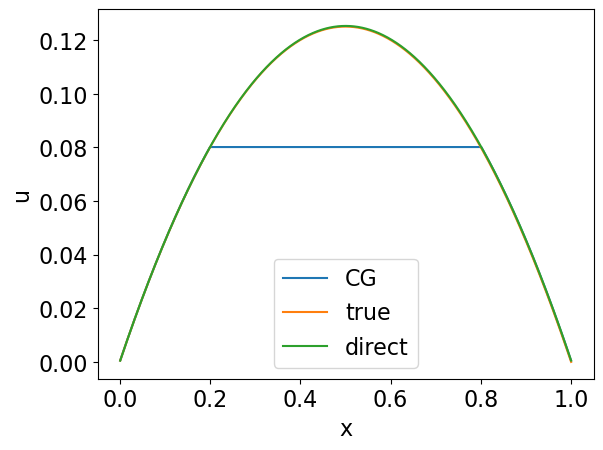

In [4]:
from scipy.linalg import toeplitz

# problem settings
L = 1
n = 1000

# discrete domain
h = L / n
x = np.linspace(h, L, n)

# create the matrix
col = np.zeros(n)
col[0:2] = np.array([2, -1]) * (1 / (h*h))
A = toeplitz(col)

# create the right-hand side
b = np.ones(n)
x0 = np.zeros(n)

w, iter = CG(A, b, x0, tol=1e-12)
u_true = - 0.5 * x * (x - L)
w_direct = np.linalg.solve(A, b)

#%% reporting
print(" CG iterations = ", iter)
print("total CG error = ", np.linalg.norm(w - u_true))
print("discretization error = ", np.linalg.norm(w_direct - u_true))
print("algebraic error = ", np.linalg.norm(w - w_direct))

#%% plotting
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots()
ax.plot(x, w, label="CG")
ax.plot(x, u_true, label="true")
ax.plot(x, w_direct, label="direct")
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.legend()
plt.show()

**Remark** 

- `numpy.linalg.solve` uses a very reliable library LAPACK. ([NumPy Documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html), [LAPACK Wikipedia page](https://en.wikipedia.org/wiki/LAPACK), [LAPACK webpage](https://www.netlib.org/lapack/)). We use its result as "true solution."

#### Notation/Settings

| expression | meaning |
|---|---|
| $x$ | true solution ($Ax=b$) |
| $x_k$ | $k$-th approximate solution by the conjugate gradient method ($k=0,1,2,\cdots$)|
| $e_k$ | $=x - x_k$ (error caused by $x_k$) |
| $r_k$ | $=b-Ax_k$ (residual caused by $x_k$) |
| $d_k$ | conjugate directions |
| $(u,v)$ | $=v^T u$ (standard inner product) |
| $(u,v)_A$ | $=v^T A u$ (A-inner product, where $A$ is a SPD matrix) |
| $v \perp_A u$ | $(u,v)_A =0$ (A-orthogonality) |

#### Idea behind the conjugate gradient method


**Remark**

A minimization approach to conjugate gradient method is also helpful, where we use the equivalence

$$
Ax = b \quad \leftrightarrow \quad \mathrm{minimize} ~ \frac{1}{2} x^T A x - b^T x, \quad \text{subject to} ~ x \in \mathbb{R}^n.
$$

However, this involves more discussions from different angles. Between the trade-off of richness and simplicity in presentation, these notes have chosen the simplicity, and do not discuss minimization approach.


##### Warm up (Gaussian elimination)

1. Change the perspective

View the process of finding the solution as removing components of error one by one. Unless we are extremely lucky, our error caused by the initial guess will be full of possible components. 

For the moment, to avoid introducing too many symbols, let us override the notations and let $d_k$'s be canonical basis of $\mathbb{R}^{n}$. 

We can expand the initial error in the canonical basis.

$$
e_{0}=\sum_{k=0}^{n-1} \eta_k d_k
$$



2. Remove component one by one

Then the back substitution step can be seen as removing $d_{n-2}$ component from the error, then $d_{n-3}$ component, all the way to $d_{0}$. ($d_{n-1}$ component is already absent since the last component of $x$ is precise.)

$$
\begin{bmatrix}
1&-\frac{1}{2}&\frac 3 4 & \frac 7 4 \\
0&1& \frac 3 5 & \frac {26} 5\\
0&0&1& \underbrace{2}_{x_1} 
\end{bmatrix}
\longrightarrow	
\begin{bmatrix}
1&-\frac{1}{2}&0 & -1 \\
0&1& 0& 4\\
0&0&1& \underbrace{2}_{x_2}  
\end{bmatrix}
\longrightarrow	
\begin{bmatrix}
1&0&0 & 1 \\
0&1& 0& 4\\
0&0&1& \underbrace{2}_{x_3}  
\end{bmatrix}
$$

![Gaussian elimination from error improvement point of view](../images/CG01.png)

**Remark**


- Removing $d_k$ from the approximate solution $x_k$ and removing it from the error $e_k$ are equivalent because they differ only by a fixed vector, the true solution $x$, that is, $e_k = x - x_k$. But the signs of $e_k$ and $x_k$ are opposite.




3. Algorithm-friendly summary


Given $x_k$, hence $e_k = x - x_k$, take exact step to remove $d_k$ component each time

$$
e_{k+1}=e_k - \eta_k d_k.
$$

or equivalently, 

$$
x_{k+1}=x_k + \eta_k d_k,
$$

The exact component $\eta_k$ in $d_k$ direction can be computed by the condition $e_{k+1} \perp d_k$ since we just subtracted out $d_k$:

$$
\begin{split}
e_{1}&=\sum_{j=1}^{n-1} \eta_j d_j
\\
e_{2}&=\sum_{j=2}^{n-1} \eta_j d_j
\\
&\vdots
\\
e_{k+1}&=\sum_{j=k+1}^{n-1} \eta_j d_j.
\end{split}
$$

By taking dot product with $d_k$ on both sides of the error update rule $e_{k+1}=e_k - \eta_k d_k$, we can find

$$
\eta_k = \frac{d_k^T e_{k}}{d_k^T d_k}.
$$


**Observation**

- $e_k$ is not computable since we do not know the true solution $x$.
- The residual $r_k:=b - Ax_k$ is computable. 
- Since $r_k = b - A x_k = A x - A x_k = A(x - x_k) = Ae_k$, the residual and the error are related:

$$
r_k = Ae_k
$$

- Though not at all trivial, these observations suggest a possibility to play between A-orthogonality and orthogonality for our needs.

##### Devising conjugate gradient method: Part 1 (main idea)

1. Suppose we have an A-orthogonal basis $\{d_k\}_{k=0}^{n-1}$ for $\mathbb{R}^n$. (We will discuss how to obtain it. For now, assume it is possible.) 



2. View finding the solution as removing $d_k$ component at a time. We can expand the initial error in this basis. 

$$
e_{0}=\sum_{k=0}^{n-1} \alpha_k d_k
$$

It is likely that the initial guess contains all components of $d_k$'s.



3. Suppose we can remove $d_k$ component from the previous error each time (this can be achieved by finding $\alpha_k$ momentarily):

$$
e_{k+1}=e_k - \alpha_k d_k  \quad \text{(error update)}.
$$

Equivalently, we can write this in terms of $x_k$'s

$$
x_{k+1}=x_k + \alpha_k d_k.
$$

Then, we are left with less and less $d_k$ components in the error:

$$
e_{k+1}=\sum_{j=k+1}^{n-1} \alpha_j d_j
$$

since

$$
\begin{split}
e_{1}&=\sum_{j=1}^{n-1} \alpha_j d_j
\\
e_{2}&=\sum_{j=2}^{n-1} \alpha_j d_j
\\
&\vdots
\end{split}
$$

Thus, since $e_{k+1}$ has no $d_k$ component (it has just been removed), we must have $e_{k+1} \perp_{A} d_k$. Use this fact to the error update rule, then we can compute $\alpha_k$:

$$
\alpha_k = \frac{d_k^T A e_k}{d_k^T A d_k}=\frac{d_k^T r_k}{d_k^T A d_k} \quad \text{(computable)}.
$$



**Remark**

- This is where $A$-orthogonality is used in a nice way.
- In the algorithm, we use $\alpha_k$ formula to update $x_k$'s since $e_k$ is not computable during implementation.
- Since there are only $n$ linearly independent directions $d_k$'s, in theory, the conjugate gradient will eventually exhaust all directions $d_k$'s at most $n$ steps and yield the solution. From this point of view, it can be seen as a direct method.

##### Devising conjugate gradient method: Part 2(conjugate directions)

**Question**: How to find the $A$-orthogonal basis $\{d_k\}$?

**Idea**: Gram-Schmidt process with respect to $A$-inner product. We will construct $d_k$'s dynamically as the algorithm proceeds.

**Observation 1**

Computation dependency (incomplete):

$$
x_k, d_k, r_k \longrightarrow \alpha_k \longrightarrow x_{k+1}, r_{k+1} \longrightarrow  d_{k+1} ~ (?)
$$

**Observation 2-(a)**

New residual $r_{k+1}$ guarantees a new direction outside of $\mathrm{span}\{d_0, d_1, \cdots, d_k \}$. In fact, if everything works out as we planned, it is orthogonal to all the past directions:

$$ 
r_{k+1} \perp \mathrm{span} \{ d_j \ : \  0 \le j \le k \}
$$

since, by mutual A-orthogonality between $d_k$'s, 

$$
d_j^T r_{k+1} = d_j^T A e_{k+1} = \sum_{i=k+1}^{n-1} \eta_k d_j^T A  d_i = 0.
$$

**Observation 2-(b)**

![Gram-Schmidt](https://upload.wikimedia.org/wikipedia/commons/7/7b/Linalg_orth_proj_R3.png)

We can extract $d_{k+1}$ from $r_{k+1}$ by filtering out $\{d_0, d_1, \cdots, d_k \}$: Gram-Schmidt.

$$
d_{k+1} = r_{k+1} +\sum_{j=0}^{k}\beta_{j} d_j,
$$

where by taking $A$-inner product with each of $d_{j}$'s, we know, for $j=0,1,\cdots,k$

$$
\beta_j = - \frac{d_j^T A r_{k+1}}{d_j^T A d_j}.
$$

**Remark**

- This turns out not to be practical in computation. We need to store $d_j$'s, but this runs out of memory quickly for large problems. However, surprisingly, we only need to store the last one. (See below)

**Observation 3**

A close look reveals $\beta_j=0$ for $j=0,1,\cdots,k-1$, meaning, we need to store only $d_k$, and the Gram-Schmidt process step reduces to 

$$
d_{k+1} = r_{k+1} +\beta_{k} d_k,
$$

where, as in the previous formular for $\beta_j$'s,

$$
\beta_k = - \frac{r_{k+1}^T A d_k^T}{d_{k}^T A d_k^T}.
$$

**Remark**

- This observation involves a fair amount of details. Hence, we skip it for now in favor of a better bigger picture.

**Complete computation dependency**

Now that we know how to compute $d_{k+1}$, we have completed a working loop:

$$
x_k, d_k, r_k \longrightarrow \alpha_k \longrightarrow x_{k+1}, r_{k+1} \longrightarrow \beta_k \longrightarrow d_{k+1}
$$

[proof of Gram-Schmidt step in conjugate gradient 1](https://jhparkyb.github.io/resources/notes/na/pf_ConjugateGradientGramSchmidtStep1_lp4000.png)

[proof of Gram-Schmidt step in conjugate gradient 2](https://jhparkyb.github.io/resources/notes/na/pf_ConjugateGradientGramSchmidtStep2_lp4000.png)

[proof of Gram-Schmidt step in conjugate gradient 3](https://jhparkyb.github.io/resources/notes/na/pf_ConjugateGradientGramSchmidtStep3_lp4000.png)

[proof of Gram-Schmidt step in conjugate gradient 3](https://jhparkyb.github.io/resources/notes/na/pf_ConjugateGradientGramSchmidtStep4_lp4000.png)

##### Some computational optimizations

The formulas for $\alpha_k$, $\beta_k$, and $r_{k+1}$ from the discussion of "devising conjugate gradient method" convey the idea behind it. However, there are equivalent expressions that are computationally more efficient.

| formula from idea | formula for computation | Advantage |
|---|---|---|
| $$\alpha_k=\frac{d_k^T r_k}{d_k^T A d_k}$$ | $$\alpha_k=\frac{r_k^T r_k}{d_k^T A d_k}$$ | recycle $r_k^T r_k$ (this is the same as $r_{k+1}^T r_{k+1}$ from the previous iteration) |
| $$x_{k+1}=x_k+\alpha_k d_k$$ | Same |
| $$r_{k+1}=b - Ax_{k+1}$$ | $$r_{k+1}=r_k-\alpha_k A d_k$$ | avoid $Ax_{k+1}$ and recycle $A d_k$ |
| $$\beta_k = - \frac{r_{k+1}^T A d_k}{d_{k}^T A d_k}$$| $$\beta_k=\frac{r_{k+1}^T r_{k+1}}{r_k^T r_k}$$ | recycle $r_k^T r_k$ and avoid $r_{k+1}^T (A d_k)$ |
| $$d_{k+1}=r_{k+1}+\beta_k d_k$$ | Same |


[proof of equivalent formulas in conjugate gradient 1](https://jhparkyb.github.io/resources/notes/na/pf_ConjugateGradientEfficientFormulas1_lp3000.png)

[proof of equivalent formulas in conjugate gradient 2](https://jhparkyb.github.io/resources/notes/na/pf_ConjugateGradientEfficientFormulas2_lp3000.png)
